In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/ObjectDetection')
import Dataread 

In [3]:
!pip install torchmetrics

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime as dt

import cv2
from xml.etree import ElementTree as et

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


import torch
import torchvision
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.2 MB/s 


In [4]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img).convert('RGB')
    a.imshow(img)
    
    boxes = target['boxes']
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()
    
    for box in (boxes):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        a.add_patch(rect)
    
    plt.axis('off')
    plt.show()
    

In [5]:
files_dir = '/content/gdrive/MyDrive/ObjectDetection/train'
test_dir = '/content/gdrive/MyDrive/ObjectDetection/test'

dataset = Dataread.FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset))

length of dataset =  240


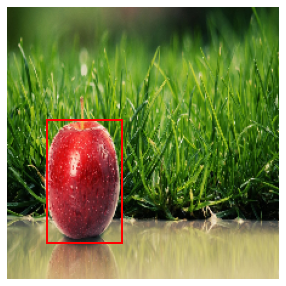

In [6]:
img, target = dataset[31]
plot_img_bbox(img, target)

In [7]:
def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


def collate_fn(batch):
    return tuple(zip(*batch))


def get_transform(train):
    if train:
        return A.Compose([A.HorizontalFlip(0.5),A.VerticalFlip(0.3),ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
dataset = Dataread.FruitImagesDataset(files_dir, 224, 224, transforms=get_transform(train=True))
dataset_test = Dataread.FruitImagesDataset(test_dir, 224, 224, transforms=get_transform(train=False))

In [9]:
torch.manual_seed(1)
np.random.seed(1)
indices = np.random.permutation(len(dataset)).tolist()

In [10]:
val_split = 0.1
tsize = len(dataset) - int(len(dataset)*val_split)

train_data = torch.utils.data.Subset(dataset, indices[:tsize])
val_data = torch.utils.data.Subset(dataset, indices[tsize:])

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True, num_workers=2, collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=5, shuffle=True, num_workers=2, collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=5, shuffle=False, num_workers=2, collate_fn=collate_fn)

n_batches, n_batches_test = len(train_loader), len(test_loader)

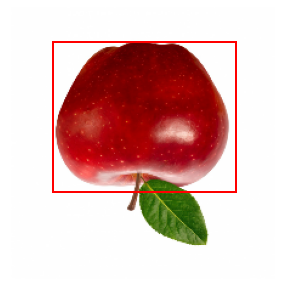

In [12]:
images, targets = next(iter(train_loader))
plot_img_bbox(images[1], targets[1])

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

model = get_object_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [14]:
map = MeanAveragePrecision()

def train_model(model, data_loader=None, num_epoch=10):

    for epoch in range(1, num_epoch + 1):
      
        print(f"Epoch {epoch:2d}/{num_epoch:2d}")

        time_start = time.time()
        loss_accum = 0.0
        loss_classifier_accum = 0.0
        
        model.train()
        
        for batch_idx, (images, targets) in enumerate(data_loader, 1):

            # Predict
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            loss_accum += loss.item()
            loss_classifier_accum += loss_dict['loss_classifier'].item()

            if batch_idx % 500 == 0:
                print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}.")

        lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        train_loss_classifier = loss_classifier_accum / n_batches

        elapsed = time.time() - time_start

        torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
        print(f"Train loss: {train_loss:7.3f} [{elapsed:.0f} secs]", end=' -- ')
        
        preds_single = []
        targets_single = []
        
        for batch_idx, (images, targets) in enumerate(val_loader, 1):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            targets_single.extend(targets)
    
            model.eval()
            with torch.no_grad():
                pred = model(images)
            
            preds_single.extend(pred)
        
        map.update(preds_single, targets_single)
        batch_map = map.compute()
        
        print(f"Val mAP: {batch_map['map']}")
        
    return model

In [16]:
num_epoch = 30
start_tr = time.time()
model = train_model(model, train_loader, num_epoch)
end_tr = time.time()
print('\n\nTime taken for train', num_epoch, 'epoch: ',end_tr - start_tr)

Epoch  1/30
Train loss:   0.467 [47 secs] -- Val mAP: 0.40761855244636536
Epoch  2/30
Train loss:   0.227 [43 secs] -- Val mAP: 0.46209919452667236
Epoch  3/30
Train loss:   0.176 [42 secs] -- Val mAP: 0.46256497502326965
Epoch  4/30
Train loss:   0.150 [42 secs] -- Val mAP: 0.48053833842277527
Epoch  5/30
Train loss:   0.131 [42 secs] -- Val mAP: 0.49677520990371704
Epoch  6/30
Train loss:   0.127 [42 secs] -- Val mAP: 0.5083721280097961
Epoch  7/30
Train loss:   0.120 [42 secs] -- Val mAP: 0.5179433822631836
Epoch  8/30
Train loss:   0.124 [42 secs] -- Val mAP: 0.5262113809585571
Epoch  9/30
Train loss:   0.123 [42 secs] -- Val mAP: 0.5313305854797363
Epoch 10/30
Train loss:   0.122 [42 secs] -- Val mAP: 0.5361223220825195
Epoch 11/30
Train loss:   0.120 [42 secs] -- Val mAP: 0.5396614670753479
Epoch 12/30
Train loss:   0.119 [42 secs] -- Val mAP: 0.5434201955795288
Epoch 13/30
Train loss:   0.119 [42 secs] -- Val mAP: 0.5461687445640564
Epoch 14/30
Train loss:   0.126 [42 secs] -- V

In [17]:
metric_test = MeanAveragePrecision()

preds_single = []
targets_single = []

for batch_idx, (images, targets) in enumerate(test_loader, 1):

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    targets_single.extend(targets)

    model.eval()
    with torch.no_grad():
        pred = model(images)

    preds_single.extend(pred)

metric_test.update(preds_single, targets_single)
test_map = map.compute()

print(f"Test mAP: {test_map['map']}")

Test mAP: 0.566322386264801


{'boxes': tensor([[ 53.0133,  58.6900, 130.6667, 160.4192],
        [  8.9600,  21.5197,  78.4000, 108.5764],
        [100.0533,  22.4978, 181.4400, 112.4891],
        [ 79.8933, 123.2489, 161.2800, 224.0000],
        [154.5600, 134.9869, 222.5067, 224.0000]]), 'labels': tensor([1, 1, 1, 1, 1]), 'area': tensor([7899.6167, 6045.2217, 7324.0889, 8199.7949, 6048.1440]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([0])}


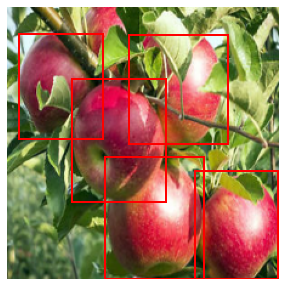

In [18]:
images, targets = next(iter(test_loader))
print(targets[0])
plot_img_bbox(images[0], targets[0])